<a href="https://colab.research.google.com/github/ferdouszislam/Bangla-Handwritting-Aesthetics-Prediction-ML/blob/main/codes/experimentation_2_class_with_label_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import copy
import torch
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# # mount gdrive with this code
# from google.colab import drive
# drive.mount('/content/drive')

# # extract the zip file containing our dataset
# import zipfile
# import os

# zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BanglaLekha-Isolated_aesthetics_dataset/2_class.zip', 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

In [4]:
# set all random seeds
SEED = 42

def set_global_seed():
  #torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = False
  #random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  #np.random.seed(SEED)

set_global_seed()

In [5]:
# custom dataset class
class BanglaAestheticsDataset(Dataset):
  def __init__(self, labels_csv_file, img_dir, transform=None):
    self.labels_df = pd.read_csv(labels_csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.labels_df.iloc[index, 0])
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
      
    y_label = torch.tensor(self.labels_df.iloc[index, 4])
    # print(y_label)
    
    return (image, y_label)

In [6]:
# load data

# resize to same shape and convert to tensor
custom_transform = transforms.Compose([transforms.ToPILImage(), 
                                       transforms.Resize((50, 50)), 
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.5,), (0.5,))
                                       ])


# train_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/2_class/aesthetics_train.csv', 
#                                         img_dir='/tmp/2_class/train_images', transform=custom_transform)
# val_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/2_class/aesthetics_val.csv', 
#                                         img_dir='/tmp/2_class/validation_images', transform=custom_transform)
# test_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/2_class/aesthetics_test.csv', 
#                                         img_dir='/tmp/2_class/test_images', transform=custom_transform)

train_dataset = BanglaAestheticsDataset(labels_csv_file='../input/banglalekhaisolated-aestheticscore-2class/2_class/aesthetics_train.csv', 
                                        img_dir='../input/banglalekhaisolated-aestheticscore-2class/2_class/train_images', transform=custom_transform)
val_dataset = BanglaAestheticsDataset(labels_csv_file='../input/banglalekhaisolated-aestheticscore-2class/2_class/aesthetics_val.csv', 
                                        img_dir='../input/banglalekhaisolated-aestheticscore-2class/2_class/validation_images', transform=custom_transform)
test_dataset = BanglaAestheticsDataset(labels_csv_file='../input/banglalekhaisolated-aestheticscore-2class/2_class/aesthetics_test.csv', 
                                        img_dir='../input/banglalekhaisolated-aestheticscore-2class/2_class/test_images', transform=custom_transform)

# data loaders

batch_size = 100 # no of samples in a single batch

set_global_seed()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
set_global_seed()
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# visualize data
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (25,4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=25).permute(1,2,0))
        #print(images.shape)
        break

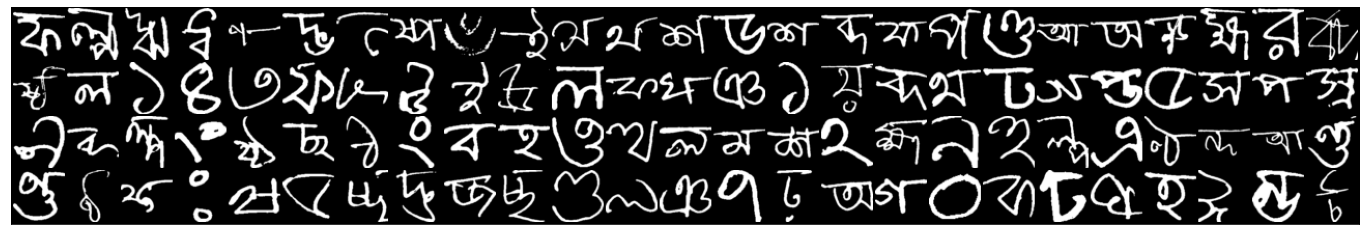

In [8]:
show_batch(val_loader)

# Experimentation with various NNs starts from here

In [9]:
# hyperparameters
INPUT_SIZE = 50*50
ANN_FC1_SIZE = 256
ANN_FC2_SIZE = 128
ANN_FC3_SIZE = 64
CONV1_FILTERS = 16
CONV2_FILTERS = 32
NUM_EPOCHS = 40
LEARNING_RATE = 0.0015

In [10]:
# custom ANN class with 3 hidden layers, relu activation and dropout on each hidden layer
class ANN(nn.Module):
  def __init__(self, input_size=INPUT_SIZE, fc1_size=256, fc2_size=128, fc3_size=64):
    super(ANN, self).__init__()
    self.input_size = input_size
    self.fc1 = nn.Linear(input_size, fc1_size)
    self.dropout_fc1 = nn.Dropout(0.75)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout_fc2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(fc2_size, fc3_size)
    self.dropout_fc3 = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc3_size, 1)

  def forward(self, input):
    # flatten input
    input = input.reshape(-1, self.input_size) 
    # input layer to hidden layer 1
    output = self.dropout_fc1(self.fc1(input))
    output = self.relu(output)
    # hidden layer 1 to hidden layer 2
    output = self.dropout_fc2(self.fc2(output))
    output = self.relu(output)
    # hidden layer 2 to hidden layer 3
    output = self.dropout_fc3(self.fc3(output))
    output = self.relu(output)
    # hidden layer 3 to output
    output = self.output_layer(output)
    pred = torch.sigmoid(output) # probability prediction
    return pred

In [11]:
# custom cnn class 
class CNN(nn.Module):
  def __init__(self, conv1_filters=16, conv2_filters=32, fc1_size=256, fc2_size=64):
    super(CNN, self).__init__()
    
    self.conv1_filters = conv1_filters
    self.conv2_filters = conv2_filters

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(1, conv1_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv1_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_layer2 =  nn.Sequential(
        nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv2_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # conv layer explanation with: conv1_filters=16, conv2_filters=32
    # 1x50x50 --conv1--> 16x50x50 --maxpool--> 16x25x25
    # 16x25x25 --conv2--> 32x25x25 --maxpool--> 32x12x12

    self.fc1 = nn.Linear(conv2_filters*12*12, fc1_size) 
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.relu = nn.ReLU()
    self.fc_dropout = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc2_size, 1)
      
  def forward(self, input):
    #print('inside forward', input.shape)

    # input to conv_layer1
    output = self.conv_layer1(input)
    #print('after conv1', output.shape)

    # conv_layer1 to conv_layer2
    output = self.conv_layer2(output)
    #print('after conv2', output.shape)

    # conv_layer2 to fc1
    output = output.reshape(-1, self.conv2_filters*12*12) # flatten
    output = self.fc1(output)
    output = self.relu(self.fc_dropout(output))

    # fc1 to fc2
    output = self.fc2(output)
    output = self.relu(self.fc_dropout(output))

    # fc2 to prediction
    output = self.output_layer(output)
    pred = torch.sigmoid(output)

    return pred

  def _get_result_dims(input_dims, conv_dims, p=0, s=1):
    # get resulting matrix(2d) dimensions after convolution
    
    resulting_dims = []
    resulting_dims.append(int((input_dims[0] - conv_dims[0] + 2*p)/s)+1)
    resulting_dims.append(int((input_dims[1] - conv_dims[1] + 2*p)/s)+1)
    
    return resulting_dims

In [12]:
# class to calculate accuracy of model, using batches of data
class Accuracy_Calc():
  def __init__(self):
    self.n_correct_samples = 0
    self.n_total_samples = 0

  def add_batch(self, pred_labels, gt_labels):
    pred_labels = torch.round(pred_labels)
    gt_labels = torch.round(gt_labels)

    self.n_total_samples+=gt_labels.size(0)
    self.n_correct_samples+=pred_labels.eq(gt_labels).sum().item()

  def get_accuracy(self):
    return 100*self.n_correct_samples/self.n_total_samples

In [13]:
PATH_TO_ANN_MODEL = 'ann_model.pth'
PATH_TO_CNN_MODEL = 'cnn_model.pth'
PATH_TO_RESNET_TRANS = 'resnet_trans.pth'
PATH_TO_ALEXNET_TRANS = 'alexnet_trans.pth'
PATH_TO_SQUEEZENET_TRANS = 'squeezenet_trans.pth'

# training loop
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, SAVE_PATH):
  since = time.time()

  min_val_loss = np.inf
  total_train_step = len(train_loader)

  train_accuracies = []
  val_accuracies = []
  train_losses = []
  val_losses = []
  selected_epoch = 0
  selected_train_acc = 0.0
  selected_val_acc = 0.0
  selected_train_loss = 0.0
  selected_val_loss = 0.0
  
  # train loop
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc_calc = Accuracy_Calc()
    
    model.train() # set the model in train mode
    for step, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accumulate training loss
      train_loss+=loss.item()
      with torch.no_grad():
        # accumulate train accuracy
        train_acc_calc.add_batch(outputs, labels)

    val_loss = 0.0
    val_acc_calc = Accuracy_Calc()

    model.eval() # set the model to evaluation mode
    with torch.no_grad():
      for step, (images, labels) in enumerate(val_loader):
        # if flatten_input:
        #   images = images.reshape(-1, 50*50) # flatten image
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        labels = labels.unsqueeze(1)
        labels = labels.float()

        loss = criterion(outputs, labels)

        # accumulate validation loss
        val_loss+=loss.item() #loss.item() * images.size(0)
        # accumulate validation accuracy
        val_acc_calc.add_batch(outputs, labels)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = train_acc_calc.get_accuracy()
    val_acc = val_acc_calc.get_accuracy()
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch} / {num_epochs-1}')
    print('-' * 15)
    print(f'train loss: {train_loss:.3f}, accuracy: {train_acc:.3f}')
    print(f'validation loss: {val_loss:.3f}, accuracy: {val_acc:.3f}')

    if val_loss < min_val_loss or (val_loss == min_val_loss and val_acc > selected_val_acc):
        print(f'validation loss decreased \t Saving The Model')
        min_val_loss = val_loss
        selected_train_acc = train_acc
        selected_train_loss = train_loss
        selected_val_acc = val_acc
        selected_val_loss = val_loss
        # Saving State Dict
        model.to(device)
        torch.save(model.state_dict(), SAVE_PATH)
        selected_epoch = epoch

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed/60.0:.3f}m {time_elapsed%60:.3f}s')
  print(f'Train Accuracy: {selected_train_acc:.3f}, Loss: {selected_train_loss:.3f}')
  print(f'Validation Accuracy: {selected_val_acc:.3f}, Loss: {selected_val_loss:.3f}')

  return selected_epoch, train_accuracies, val_accuracies, train_losses, val_losses

# evaluation 
def eval(model, test_loader):
  model.eval()
  with torch.no_grad():
    n_correct_samples = 0
    n_total_samples = 0
    for imgs, labels in test_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      outputs = model(imgs)

      #preds = outputs.round() # if outputs>=0.5 class = 1, else class = 0
      preds = torch.round(outputs)
      labels = torch.round(labels)

      # print(preds.type(), labels.type())

      #print(pred.shape, labels.shape)
      
      n_total_samples+=labels.size(0)
      n_correct_samples+=preds.eq(labels).sum().item()

    print(f'Accuracy = {100*n_correct_samples/n_total_samples : 0.3f}')

# plot lists of train, validation scores- accuracy, loss etc
def plot_scores(score_type, train_scores, val_scores, num_epochs=NUM_EPOCHS, selected_epoch=None):
  plt.figure(figsize =(15,9))
  plt.title(f"train vs validation {score_type}", fontdict = {'fontsize' : 18})
  epochs = [epoch for epoch in range(num_epochs)]
  plt.plot(epochs, train_scores, 'ro-',  epochs, val_scores ,'bv-')

  if selected_epoch:
    plt.axvline(x=selected_epoch, color='k', linestyle='--')
    plt.legend([f'train {score_type}',f'validation {score_type}', 'selected epoch'], fontsize=16)
  
  plt.xlabel('epochs', fontsize=18)
  plt.ylabel(score_type, fontsize=18)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.show()

# **Custom ANN**

In [ ]:
# # init model with ANN
# set_global_seed()
# model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
# model = model.to(device)

# # init loss function, optimizer
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# selected_epoch, train_accs, val_accs, train_losses, val_losses = train(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_ANN_MODEL)

In [ ]:
# plot_scores("accuracy", train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
# plot_scores("loss", train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
# model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
# model.load_state_dict(torch.load(PATH_TO_ANN_MODEL))
# model = model.to(device)
# eval(model=model, test_loader=test_loader)

# **Custom CNN**

In [ ]:
# init model with CNN
set_global_seed()
model = CNN()
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

selected_epoch, train_accs, val_accs, train_losses, val_losses = train(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_CNN_MODEL)

In [ ]:
plot_scores("accuracy", train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores("loss", train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
model = CNN()
model.load_state_dict(torch.load(PATH_TO_CNN_MODEL))
model = model.to(device)
eval(model=model, test_loader=test_loader)

# **Transfer Learning**

In [14]:
from torchvision import models

In [15]:
# resize to same shape and convert to tensor
tm_transform = transforms.Compose([transforms.ToPILImage(), 
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda img: img.repeat(3, 1, 1) ), # repeat single channel thrice to get 3-channel 
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])

# load datasets
tm_train_dataset = BanglaAestheticsDataset(labels_csv_file='../input/banglalekhaisolated-aestheticscore-2class/2_class/aesthetics_train.csv', 
                                        img_dir='../input/banglalekhaisolated-aestheticscore-2class/2_class/train_images', transform=tm_transform)
tm_val_dataset = BanglaAestheticsDataset(labels_csv_file='../input/banglalekhaisolated-aestheticscore-2class/2_class/aesthetics_val.csv', 
                                        img_dir='../input/banglalekhaisolated-aestheticscore-2class/2_class/validation_images', transform=tm_transform)
tm_test_dataset = BanglaAestheticsDataset(labels_csv_file='../input/banglalekhaisolated-aestheticscore-2class/2_class/aesthetics_test.csv', 
                                        img_dir='../input/banglalekhaisolated-aestheticscore-2class/2_class/test_images', transform=tm_transform)

# data-loaders

batch_size = 100 # no of samples in a single batch

set_global_seed()
tm_train_loader = DataLoader(dataset=tm_train_dataset, batch_size=batch_size, shuffle=True)
set_global_seed()
tm_val_loader = DataLoader(dataset=tm_val_dataset, batch_size=batch_size, shuffle=True)
tm_test_loader = DataLoader(dataset=tm_test_dataset, batch_size=batch_size, shuffle=False)

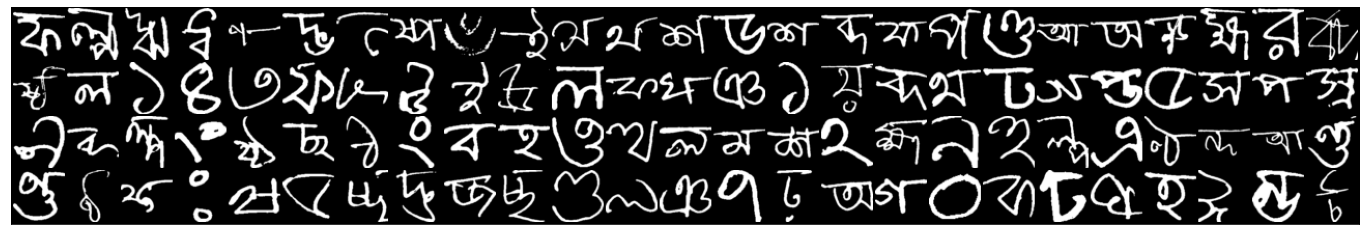

In [16]:
show_batch(val_loader)

In [17]:
class TransferModel(nn.Module):
  def __init__(self, model_name='resnet-18'):
    super(TransferModel, self).__init__()
    
    if model_name == 'resnet-18':
      self.base_model = models.resnet18(pretrained=True)
    elif model_name == 'alexnet':
      self.base_model = models.alexnet(pretrained=True)
    elif model_name == 'squeezenet':
      self.base_model = models.squeezenet1_1(pretrained=True)
    
    # freeze resnet beginning layers
    for param in self.base_model.parameters():
      param.requires_grad = False

    # output to one neuron
    if model_name == 'resnet-18':
      self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)
    elif model_name == 'alexnet':
      self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, 1)
    elif model_name == 'squeezenet':
      self.base_model.classifier._modules["1"] = nn.Conv2d(512, 1, kernel_size=(1, 1))


  def forward(self, input):
    output = self.base_model(input)
    return torch.sigmoid(output)

### ResNet

In [ ]:
# class ResNetTM(nn.Module):
#   def __init__(self):
#     super(ResNetTM, self).__init__()

#     # # convert 1 channel to 3 channels
#     # self.conv = nn.Sequential(
#     #     nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
#     #     nn.BatchNorm2d(3),
#     #     nn.Dropout(0.25),
#     #     nn.ReLU()
#     # )
    
#     # ResNet-18
#     self.base_model = models.resnet18(pretrained=True)
#     # freeze resnet beginning layers
#     for param in self.base_model.parameters():
#       param.requires_grad = False

#     # output to one neuron
#     self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

#   def forward(self, input):
#     output = self.base_model(input)
#     return torch.sigmoid(output)

In [18]:
# init model with ResNet-18
set_global_seed()

model = TransferModel('resnet-18')
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

selected_epoch, train_accs, val_accs, train_losses, val_losses = train(model, optimizer, criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_RESNET_TRANS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0 / 39
---------------
train loss: 0.679, accuracy: 65.580
validation loss: 0.672, accuracy: 68.721
validation loss decreased 	 Saving The Model

Epoch 1 / 39
---------------
train loss: 0.676, accuracy: 66.727
validation loss: 0.674, accuracy: 68.253

Epoch 2 / 39
---------------
train loss: 0.676, accuracy: 66.833
validation loss: 0.672, accuracy: 69.439

Epoch 3 / 39
---------------
train loss: 0.676, accuracy: 67.081
validation loss: 0.673, accuracy: 68.971

Epoch 4 / 39
---------------
train loss: 0.676, accuracy: 66.917
validation loss: 0.682, accuracy: 63.868

Epoch 5 / 39
---------------
train loss: 0.676, accuracy: 66.985
validation loss: 0.675, accuracy: 67.902

Epoch 6 / 39
---------------
train loss: 0.676, accuracy: 67.057
validation loss: 0.671, accuracy: 69.609
validation loss decreased 	 Saving The Model

Epoch 7 / 39
---------------
train loss: 0.675, accuracy: 67.302
validation loss: 0.671, accuracy: 69.741

Epoch 8 / 39
---------------
train loss: 0.676, accura

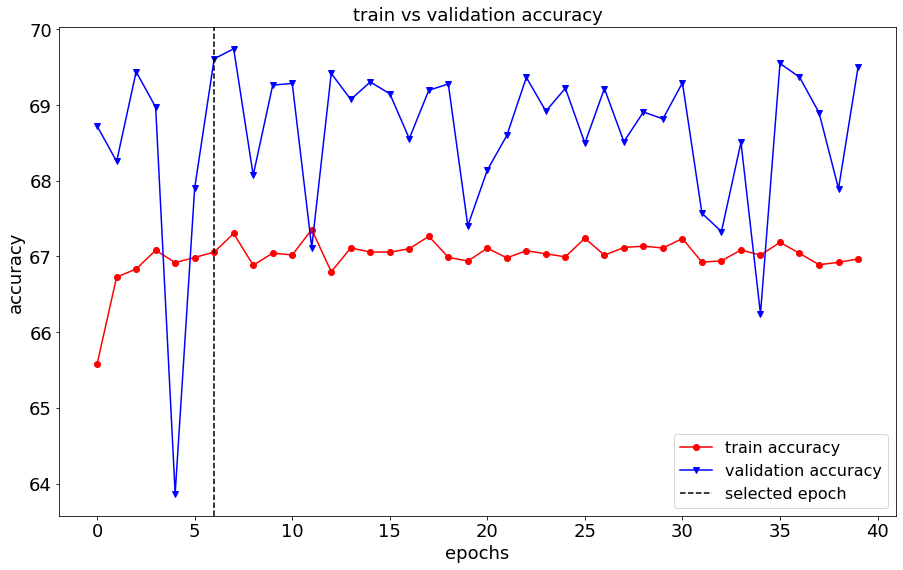

In [19]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

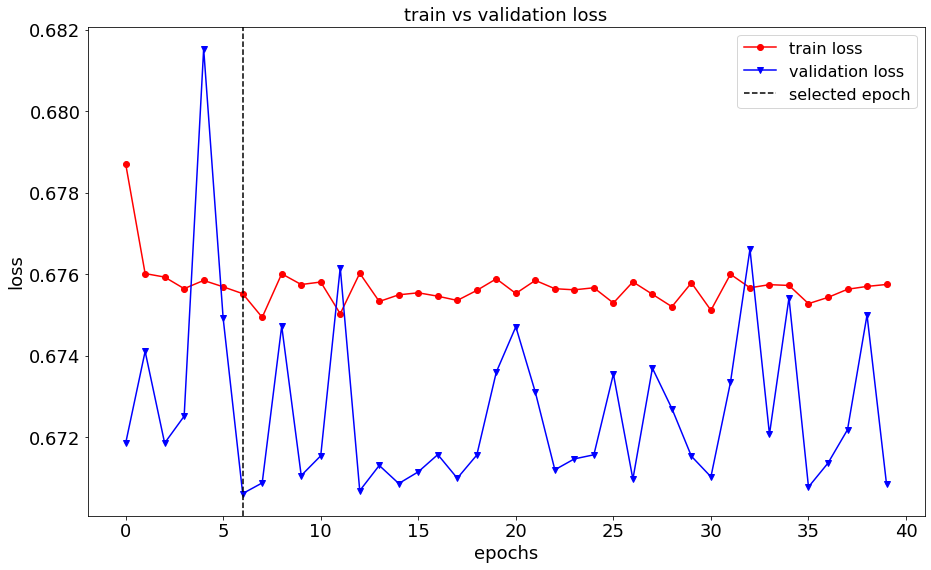

In [20]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [21]:
model = TransferModel('resnet-18')
model.load_state_dict(torch.load(PATH_TO_RESNET_TRANS))
model = model.to(device)
eval(model=model, test_loader=tm_test_loader)

Accuracy =  66.703


### AlexNet

In [ ]:
# # init model with AlexNet
# set_global_seed()

# model = TransferModel('alexnet')
# model = model.to(device)

# # init loss function, optimizer
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# selected_epoch, train_accs, val_accs, train_losses, val_losses = train(model, optimizer, criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_ALEXNET_TRANS)

In [ ]:
# plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
# plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
# model = TransferModel('alexnet')
# model.load_state_dict(torch.load(PATH_TO_ALEXNET_TRANS))
# model = model.to(device)
# eval(model=model, test_loader=tm_test_loader)

### SqueezeNet

In [ ]:
# init model with SqueezeNet1_1
set_global_seed()

model = TransferModel('squeezenet')
model = model.to(device)

# init loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

selected_epoch, train_accs, val_accs, train_losses, val_losses = train(model, optimizer, criterion, tm_train_loader, tm_val_loader, NUM_EPOCHS, SAVE_PATH=PATH_TO_SQUEEZENET_TRANS)

In [ ]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

In [ ]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

In [ ]:
model = TransferModel('squeezenet')
model.load_state_dict(torch.load(PATH_TO_SQUEEZENET_TRANS))
model = model.to(device)
eval(model=model, test_loader=tm_test_loader)